<a href="https://colab.research.google.com/github/dimLMT/Metabolic-Syndrome-Forecast/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn Display
from sklearn import set_config
set_config(transform_output='pandas')
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
import joblib
# Confirm the file was saved by loading it back in
loaded = joblib.load('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/part1.joblib')
loaded.keys()

dict_keys(['X_train_tf', 'y_train', 'X_test_tf', 'y_test', 'model', 'permutation_importances', 'X', 'y'])

In [3]:
# Loading data and objects in a new notebook
X_train_tf = loaded['X_train_tf']
y_train = loaded['y_train']
X_test_tf = loaded['X_test_tf']
y_test = loaded['y_test']
model = loaded['model']
old_permutation_importances = loaded['permutation_importances']
X = loaded['X']
y = loaded['y']

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues',cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train': results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      0.99       616
   No MetSyn       1.00      0.99      1.00      1184

    accuracy                           1.00      1800
   macro avg       0.99      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



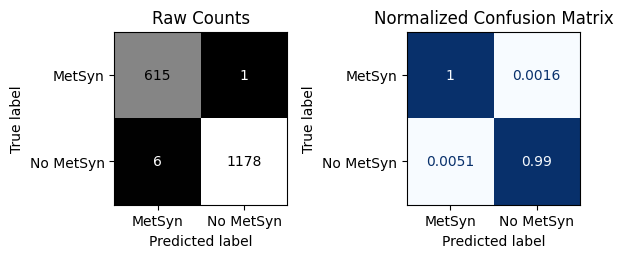

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.76      0.86      0.81       206
   No MetSyn       0.92      0.86      0.89       395

    accuracy                           0.86       601
   macro avg       0.84      0.86      0.85       601
weighted avg       0.87      0.86      0.86       601



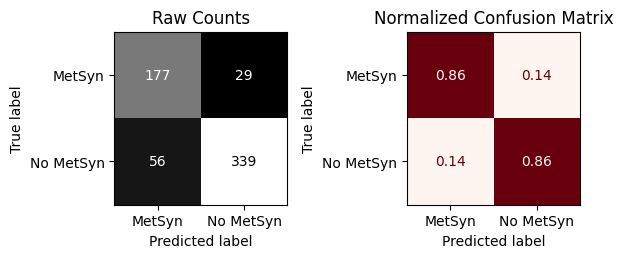

In [5]:
# restore last used model
results = evaluate_classification(model, X_train_tf, y_train, X_test_tf, y_test)

In [6]:
pd.set_option('display.max_columns', None)
X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,,
69151,0.479889,1.524161,-0.154930,-0.346375,-0.369369,-0.151810,-0.465579,0.215100,0.615647,-0.589530,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70567,1.789367,-0.898446,0.210650,-0.528455,1.988308,0.035267,0.783160,-0.426943,-0.824293,-0.047159,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64333,-0.146383,-0.736939,-0.741118,-0.331201,-0.369369,-0.158786,-1.159324,-0.175709,0.353840,0.517349,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68115,1.789367,-0.736939,-0.835665,-0.437415,-0.369369,-0.051190,1.199407,0.550078,0.092033,-0.091434,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
67719,-0.772656,1.265750,-0.993242,-0.604322,4.345986,2.238468,1.130032,-1.934347,1.008358,-0.157847,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
X_train_tf= X_train_tf.rename({'Sex_Female':'Is_Female'}, axis=1)
X_train_tf= X_train_tf.drop(['Sex_Male'], axis=1)
X_test_tf= X_test_tf.rename({'Sex_Female':'Is_Female'}, axis=1)
X_test_tf= X_test_tf.drop(['Sex_Male'], axis=1)
X_test_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,
71097,-1.569729,-1.286064,-1.440762,-0.740883,-0.369369,-0.111308,-0.743077,-0.454858,0.419292,-0.545254,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63684,0.309088,-0.252418,0.109800,0.032960,-0.369369,-0.114944,-0.118707,-0.008219,0.288388,-0.523117,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67939,1.333897,1.524161,-0.287295,-0.589149,-0.369369,-0.158786,-0.604328,0.270930,2.513749,-0.246397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67195,0.024418,0.361309,0.248468,0.154347,-0.369369,-0.153248,-0.188082,-0.371113,-0.235226,-0.700217,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70058,-0.601854,-0.252418,-1.465975,-1.180911,-0.369369,-0.154431,0.158790,-0.036134,0.222936,-0.556323,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Using PCA to speed up learning and reduce dimensionality

In [8]:
from sklearn.decomposition import PCA
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf_scaled = scaler.fit_transform(X_train_tf)
X_test_tf_scaled = scaler.transform(X_test_tf)

In [9]:
# Define PCA to address 85% of the variance
pca85 = PCA(n_components=.85)
# fit and transform on training data
X_train_pca85 = pca85.fit_transform(X_train_tf_scaled)
# transform test data
X_test_pca85 = pca85.transform(X_test_tf_scaled)
# obtain the number of PCs used
pca85.n_components_

14

In [10]:
from sklearn.ensemble import BaggingClassifier
# Instantiate a default Bagged Tree model
bagtree = BaggingClassifier(random_state = 42)
# Fit the model pipeline on the training data only
bagtree.fit(X_train_pca85, y_train)

BaggingClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.97      1.00      0.98       616
   No MetSyn       1.00      0.99      0.99      1184

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



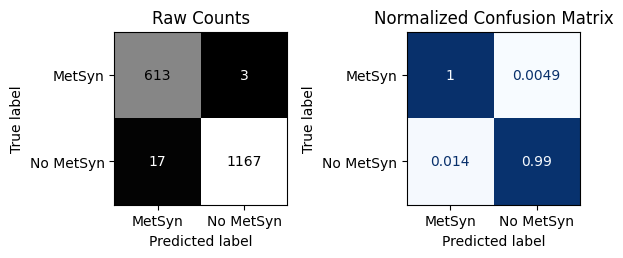

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.69      0.77      0.72       206
   No MetSyn       0.87      0.82      0.84       395

    accuracy                           0.80       601
   macro avg       0.78      0.79      0.78       601
weighted avg       0.81      0.80      0.80       601



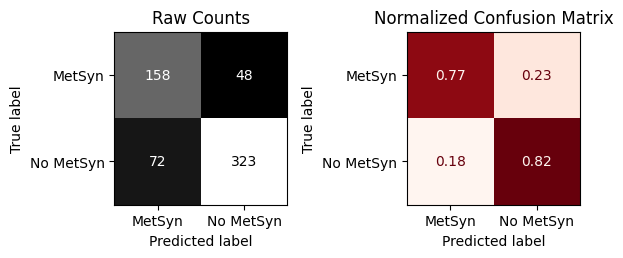

In [11]:
# Test the function
results = evaluate_classification(bagtree,X_train_pca85, y_train, X_test_pca85, y_test)

In [12]:
pca85.explained_variance_ratio_

array([0.12632425, 0.09097926, 0.08080248, 0.06812303, 0.06396268,
       0.05981434, 0.05170384, 0.04989629, 0.04763263, 0.04697875,
       0.0447895 , 0.04365233, 0.04044139, 0.03787827])

In [13]:
X_train_pca85.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13
seqn,,,,,,,,,,,,,,
69151,-0.388105,-2.106494,0.342702,-0.808084,-0.473135,0.260133,0.604785,-0.299438,0.154853,-0.025823,0.161755,-0.025564,0.668751,-0.572025
70567,1.564047,-1.532894,1.041353,0.160780,0.587931,1.229555,0.902642,-0.668475,-0.014636,0.159899,-0.174584,0.566905,0.056753,-0.786090
64333,-1.024923,0.102034,-0.046270,0.873005,1.341274,1.059892,-2.322850,0.182877,2.109392,-1.281992,0.430763,-0.242290,-0.808293,1.076419
68115,0.544153,0.069996,2.490633,-1.550615,1.083924,1.542532,-1.129095,0.854332,-2.399780,-0.268226,-0.701984,1.066968,-0.636119,-0.541246
67719,-0.020445,-0.017086,2.325261,2.852432,-1.593292,1.202874,3.140087,-1.908863,0.380111,-0.130956,0.770592,-0.673855,-0.307113,0.051512


In [14]:
# to keep only 3 principal components
pca = PCA(n_components=3)
# fit and transform on training data
X_train_pca3 = pca.fit_transform(X_train_tf_scaled)
# transform test data
X_test_pca3 = pca.transform(X_test_tf_scaled)

In [15]:
#combine these PC’s with the original features
sum_scaled_train=pd.merge(X_train_tf_scaled,X_train_pca3,on='seqn')
sum_scaled_test=pd.merge(X_test_tf_scaled,X_test_pca3,on='seqn')

### Apply Clustering to predict

In [16]:
X=pd.concat([X_train_tf_scaled, X_test_tf_scaled])
sum_X=pd.concat([sum_scaled_train, sum_scaled_test])

In [17]:
from sklearn.cluster import KMeans
# Instantiate KMeans for 2 clusters
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 42)
kmeans.fit(X)
# Save the cluster labels to the dataframe
sum_X['cluster'] = kmeans.labels_
sum_X.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,pca0,pca1,pca2,cluster
seqn,,,,,,,,,,,,,,,,,,,,,,,,,,,
69151,0.479889,1.524161,-0.154930,-0.346375,-0.369369,-0.151810,-0.465579,0.215100,0.615647,-0.589530,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,-0.387510,-2.105088,0.370987,1
70567,1.789367,-0.898446,0.210650,-0.528455,1.988308,0.035267,0.783160,-0.426943,-0.824293,-0.047159,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,1.563621,-1.547230,1.083849,0
64333,-0.146383,-0.736939,-0.741118,-0.331201,-0.369369,-0.158786,-1.159324,-0.175709,0.353840,0.517349,-1.015678,2.981629,-1.003339,-0.299313,-0.208514,-0.509531,-0.268452,2.396158,-0.550821,-0.352558,-0.334361,-0.15644,-0.789357,-1.025546,0.115333,-0.109558,1
68115,1.789367,-0.736939,-0.835665,-0.437415,-0.369369,-0.051190,1.199407,0.550078,0.092033,-0.091434,0.984564,-0.335387,-1.003339,-0.299313,-0.208514,-0.509531,3.725055,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,0.545007,0.083881,2.513661,0
67719,-0.772656,1.265750,-0.993242,-0.604322,4.345986,2.238468,1.130032,-1.934347,1.008358,-0.157847,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,1.815473,-0.352558,-0.334361,-0.15644,-0.789357,-0.020303,-0.028672,2.357670,1


In [18]:
kmeans.labels_.sum()/len(sum_X)

0.5481049562682215

In [19]:
import plotly.express as px
px.scatter_3d(x=sum_X['pca0'], y=sum_X['pca1'], z=sum_X['pca2'], color=sum_X['cluster'], symbol=pd.concat([y_train, y_test]))

### Clustering model into 2 groups cannot fully distinguish whether someone has the syndrome or not.

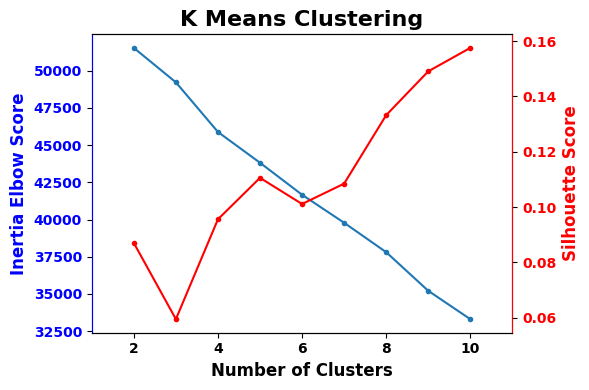

In [20]:
from sklearn.metrics import silhouette_score
## Create empty lists for scores
inertias = []
silhouette_scores = []

## Loop through k values between 2 and 10
## and store the scores in the list
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

## Visualize the scores
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title('K Means Clustering', fontsize = 16, weight='bold')

ax1.plot(range(2, 11), inertias, marker = '.')
ax1.set_ylabel('Inertia Elbow Score', color='blue', fontsize = 12, weight='bold')
plt.xlabel('Number of Clusters', fontsize = 12, weight='bold')
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold')
ax1.tick_params(axis='y', labelcolor='b')
ax1.xaxis.set_ticks(np.arange(0, 12, 2))

plt.xlim([1, 11])

ax2 = ax1.twinx()
ax2.plot(range(2, 11), silhouette_scores, color='r', marker = '.')
ax2.set_ylabel('Silhouette Score', color='r', fontsize = 12, weight='bold', )
plt.yticks(fontsize = 10, weight='bold');
ax2.tick_params(axis='y', labelcolor='r')

ax2.spines['left'].set_color('blue');
ax2.spines['right'].set_color('r');

plt.tight_layout();

In [21]:
# Instantiate KMeans for 10 clusters
kmeans = KMeans(n_clusters = 10, n_init = 'auto', random_state = 42)
kmeans.fit(X)
# Save the cluster labels to the dataframe
sum_X['cluster'] = kmeans.labels_

In [22]:
X_train_new=sum_X.iloc[:len(X_train_tf_scaled)]
X_test_new=sum_X.iloc[len(X_train_tf_scaled):]
X_test_new.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,pca0,pca1,pca2,cluster
seqn,,,,,,,,,,,,,,,,,,,,,,,,,,,
71097,-1.569729,-1.286064,-1.440762,-0.740883,-0.369369,-0.111308,-0.743077,-0.454858,0.419292,-0.545254,-1.015678,-0.335387,-1.003339,-0.299313,-0.208514,1.962588,-0.268452,-0.417335,1.815473,-0.352558,-0.334361,-0.15644,-0.789357,-2.160717,2.359945,-0.976537,6
63684,0.309088,-0.252418,0.109800,0.032960,-0.369369,-0.114944,-0.118707,-0.008219,0.288388,-0.523117,0.984564,2.981629,-1.003339,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,1.815473,-0.352558,-0.334361,-0.15644,-0.789357,-0.120381,1.744877,1.030307,4
67939,1.333897,1.524161,-0.287295,-0.589149,-0.369369,-0.158786,-0.604328,0.270930,2.513749,-0.246397,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,-0.900085,-2.213058,1.445779,1
67195,0.024418,0.361309,0.248468,0.154347,-0.369369,-0.153248,-0.188082,-0.371113,-0.235226,-0.700217,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,0.193409,-1.623005,-0.316821,1
70058,-0.601854,-0.252418,-1.465975,-1.180911,-0.369369,-0.154431,0.158790,-0.036134,0.222936,-0.556323,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,2.396158,-0.550821,-0.352558,-0.334361,-0.15644,-0.789357,-1.845262,-1.671682,-0.273030,2


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      0.99       616
   No MetSyn       1.00      0.99      1.00      1184

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



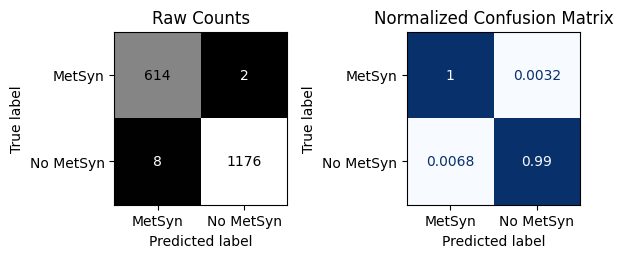

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.76      0.83      0.79       206
   No MetSyn       0.90      0.86      0.88       395

    accuracy                           0.85       601
   macro avg       0.83      0.84      0.84       601
weighted avg       0.85      0.85      0.85       601



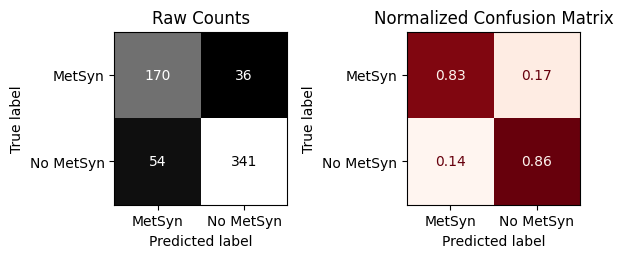

In [23]:
# Fit the model pipeline on the training data only
bagtree.fit(X_train_new, y_train)
# Test the function
results = evaluate_classification(bagtree,X_train_new, y_train, X_test_new, y_test)

### The additional features improve the model only a little. We want to try other feature engineering techniques.

In [26]:
#!pip install collinearity
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif
# Instantiate the selector, also include the appropriate scoring metric for the task
selector = SelectNonCollinear(correlation_threshold = 0.85, scoring = f_classif)
# Fit on the training data, use .values
selector.fit(X_train_tf.values, y_train.values)
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear.count(False)

1

In [27]:
# Filter column names
columns = np.array(X_train_tf.columns)[non_collinear]
# Filter training data
training_data_to_keep = X_train_tf.values[:, non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

In [28]:
from sklearn.feature_selection import VarianceThreshold
# checking for quasi-constant-features()
selector = VarianceThreshold(threshold=0.03)
selector.fit(X_train_no_corr)
# get support returns true/false for keeping features
keep_features = selector.get_support()
# Number of quasi-constant features to remove
len(keep_features)-keep_features.sum()

1

In [29]:
# Filter based on variance
X_train_var = X_train_no_corr.loc[:,keep_features]
X_test_var = X_test_no_corr.loc[:,keep_features]
X_train_var.head()

,Age,Income,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_White
0,0.479889,1.524161,-0.154930,-0.369369,-0.151810,-0.465579,0.215100,0.615647,-0.589530,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.789367,-0.898446,0.210650,1.988308,0.035267,0.783160,-0.426943,-0.824293,-0.047159,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.146383,-0.736939,-0.741118,-0.369369,-0.158786,-1.159324,-0.175709,0.353840,0.517349,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.789367,-0.736939,-0.835665,-0.369369,-0.051190,1.199407,0.550078,0.092033,-0.091434,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.772656,1.265750,-0.993242,4.345986,2.238468,1.130032,-1.934347,1.008358,-0.157847,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
from sklearn.feature_selection import SequentialFeatureSelector
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(bagtree, n_features_to_select=20,
                                direction = 'forward', cv=3,
                                 n_jobs=-1)
sk_sfs.fit(X_train_var,y_train)

SequentialFeatureSelector(cv=3, estimator=BaggingClassifier(random_state=42),
                          n_features_to_select=20, n_jobs=-1)

In [31]:
# gt an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_20 = X_train_var.loc[:,features_to_keep]
X_test_20 = X_test_var.loc[:,features_to_keep]
X_train_20.shape

(1800, 20)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      1.00       616
   No MetSyn       1.00      1.00      1.00      1184

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



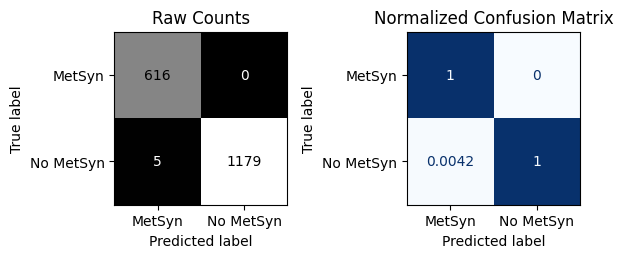

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.74      0.87      0.80       206
   No MetSyn       0.93      0.84      0.88       395

    accuracy                           0.85       601
   macro avg       0.83      0.86      0.84       601
weighted avg       0.86      0.85      0.85       601



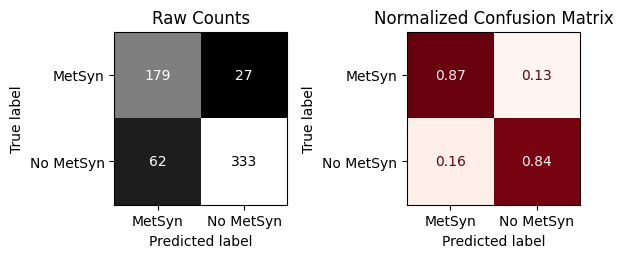

In [32]:
# Fit the model pipeline on the training data only
bagtree.fit(X_train_20, y_train)
# Test the function
results = evaluate_classification(bagtree,X_train_20, y_train, X_test_20, y_test)

### We excluded some features, but the model showed no improvement

In [33]:
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(bagtree, X_test_20, y_test, n_repeats =8, random_state =42)
new_permutation_importances = pd.Series(r['importances_mean'],index=X_test_20.columns,
                           name = 'permutation importance')
new_permutation_importances = new_permutation_importances.sort_values(ascending=False)

In [34]:
new_permutation_importances

BloodGlucose         0.076539
WaistCirc            0.052205
Triglycerides        0.048045
Is_Female            0.027662
HDL                  0.016847
Marital_Single       0.002288
Race_Asian           0.001456
Race_White           0.000624
Race_Black           0.000208
Albuminuria          0.000000
Marital_Separated    0.000000
Race_MexAmerican    -0.000416
Marital_Missing     -0.000832
UrAlbCr             -0.001040
Race_Hispanic       -0.001456
Marital_Divorced    -0.001664
Marital_Widowed     -0.002080
Income              -0.002704
Age                 -0.003328
Marital_Married     -0.004368
Name: permutation importance, dtype: float64

In [35]:
old_permutation_importances

BloodGlucose         0.084651
Triglycerides        0.064060
HDL                  0.033902
WaistCirc            0.032862
Sex_Male             0.010191
Age                  0.008111
BMI                  0.004368
Marital_Married      0.002704
Sex_Female           0.002080
Race_MexAmerican     0.000832
Marital_Single       0.000832
Marital_Missing      0.000208
Race_Other           0.000000
Marital_Separated    0.000000
Race_White           0.000000
Marital_Widowed     -0.000208
Albuminuria         -0.000208
Race_Asian          -0.000624
UrAlbCr             -0.001872
Race_Black          -0.002080
Marital_Divorced    -0.002288
Race_Hispanic       -0.002912
Income              -0.003120
UricAcid            -0.003536
Name: permutation importance, dtype: float64

### The top 10 features underwent significant changes; 'age' and 'BMI' were dropped, while 'BloodGlucose,' 'Triglycerides,' 'HDL,' 'WaistCirc,' and 'Sex' remained important. We can test with only positive importances.

In [36]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(bagtree, n_features_to_select=11,
                                direction = 'backward', cv=3,
                                 n_jobs=-1)
sk_sfs.fit(X_train_var,y_train)

SequentialFeatureSelector(cv=3, direction='backward',
                          estimator=BaggingClassifier(random_state=42),
                          n_features_to_select=11, n_jobs=-1)

In [37]:
# gt an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_11 = X_train_var.loc[:,features_to_keep]
X_test_11 = X_test_var.loc[:,features_to_keep]
X_train_11.shape

(1800, 11)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      1.00       616
   No MetSyn       1.00      1.00      1.00      1184

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



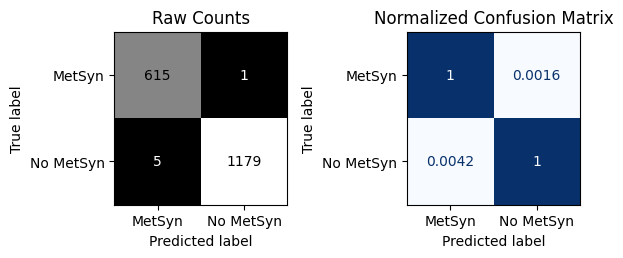

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.76      0.83      0.79       206
   No MetSyn       0.91      0.86      0.88       395

    accuracy                           0.85       601
   macro avg       0.83      0.85      0.84       601
weighted avg       0.86      0.85      0.85       601



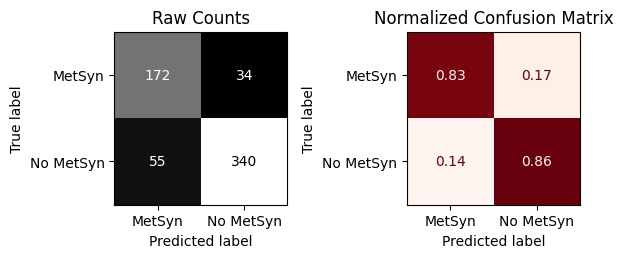

In [38]:
# Fit the model pipeline on the training data only
bagtree.fit(X_train_11, y_train)
# Test the function
results = evaluate_classification(bagtree,X_train_11, y_train, X_test_11, y_test)

In [40]:
r = permutation_importance(bagtree, X_test_11, y_test, n_repeats =8, random_state =42)
new_permutation_importances = pd.Series(r['importances_mean'],index=X_test_11.columns,
                           name = 'permutation importance')
new_permutation_importances.sort_values(ascending=False)


BloodGlucose        0.075083
Triglycerides       0.053661
WaistCirc           0.046381
Is_Female           0.027870
HDL                 0.017471
Race_White          0.001456
Albuminuria         0.000000
Race_MexAmerican   -0.001456
Marital_Married    -0.002288
Age                -0.004160
UrAlbCr            -0.005200
Name: permutation importance, dtype: float64